# Network theory

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import networkx as nx

%matplotlib inline

### Load Data

In [3]:
#load data
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks_predicted_genres.csv")

#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()


,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_genre,predicted_genre_prob,predicted_classical_prob,predicted_country_prob,predicted_electronic_prob,predicted_jazz_prob,predicted_pop_prob,predicted_rap_prob,predicted_rnb_prob,predicted_rock_prob
0,4VuS959DSpr82t3qBqCrWG,Supermarket Flowers,6eUKZXaKkcviH0Ku9w2n3V,Ed Sheeran,3T4tUhGYeRNVUGevb0wThu,221106,2017-03-03,78,0.589,0.242,...,jazz,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1Qi2wh8fFgDV7tl4Sj3f2K,Have Yourself A Merry Little Christmas,2wY79sveU1sp5g7SokKOiI,Sam Smith,3nCpXy6LlyXWuFR08tMycK,170964,2014-12-05,58,0.438,0.178,...,jazz,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,66y7x28jXOPrcmu3D5Zjh6,A Million Dreams (Reprise),6Y20PijIkUoCtuvtkz37dO,Austyn Johnson,7ayBZIe1FHkNv0T5xFCX6F,60453,2017-12-08,67,0.253,0.139,...,classical,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,14BG5B1EJSCyNpZt096xXc,"Patawad, Paalam",0rZRTXEmmPmx6gt92tBqIc,Moira Dela Torre,4Lavp71TTVIdkw8yNY8LhA,323140,2019-06-14,59,0.472,0.288,...,jazz,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1iSZPndzmY6NvL1jAtIvY1,I'm Upset,3TVXtAsR1Inumwj472S9r4,Drake,2o9McLtDM7mbODV7yZF2mc,214466,2018-06-29,0,0.899,0.587,...,rap,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
chart_tracks_df.shape

(2292, 30)

#### Limit  pool to songs that have reached top 50 from 2019 to present

In [5]:
charts_df = pd.read_csv("data/spotify_daily_charts.csv")
#transform date column into a datetime column
charts_df = charts_df.set_index(pd.to_datetime(charts_df['date'])).drop('date',1)
charts_df.head()

,position,track_id,track_name,artist,streams
date,,,,,
2018-01-01,1,0ofbQMrRDsUaVKq2mGLEAb,Havana,Camila Cabello,155633
2018-01-01,2,0tgVpDi06FyKpA1z0VMD4v,Perfect,Ed Sheeran,134756
2018-01-01,3,3hBBKuWJfxlIlnd9QFoC8k,What Lovers Do (feat. SZA),Maroon 5,130898
2018-01-01,4,1mXVgsBdtIVeCLJnSnmtdV,Too Good At Goodbyes,Sam Smith,130798
2018-01-01,5,2ekn2ttSfGqwhhate0LSR0,New Rules,Dua Lipa,125472


In [62]:
tracks_in_top50 = charts_df[(charts_df['position']<=50)]["2019-01-01":]['track_id'].unique()
track_names_dict = {t:chart_tracks_df[chart_tracks_df['track_id']==t]['track_name'].values[0]
                        for t in tracks_in_top50}
len(tracks_in_top50)

458

### 3. Building a Recommendation Graph Structure: Audio Features

In [54]:
from sklearn.metrics.pairwise import cosine_similarity
import itertools

In [60]:
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',\
                'instrumentalness','liveness', 'valence', 'tempo']
track_pairs = [pair for pair in itertools.combinations(tracks_in_top50,2)]
len(track_pairs)

104653

In [156]:
#create edge list
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',\
                'instrumentalness','liveness', 'valence', 'tempo']

#loop over all tracks
distances=np.zeros(len(track_pairs))
for n,tracks in enumerate(track_pairs):
    if (n % 1000 == 0):
        print( "Computed pairwise distances for %d/%d track pairs..." % (n+1,len(track_pairs)))

    track1_measures = chart_tracks_df[chart_tracks_df['track_id']==tracks[0]]\
                                     [feature_cols].values.reshape(1, -1)
    track2_measures = chart_tracks_df[chart_tracks_df['track_id']==tracks[1]]\
                                         [feature_cols].values.reshape(1, -1) 
    distances[n] = 1-cosine_similarity(track1_measures,track2_measures).flatten()[0]
distances_df = pd.DataFrame({'track1':[t[0] for t in track_pairs],\
                             'track1_name':[track_names_dict[t[0]] for t in track_pairs],\
                            'track2':[t[1] for t in track_pairs],\
                            'track2_name':[track_names_dict[t[1]] for t in track_pairs],\
                            'distance': distances})
distances_df

0.018573232184581134


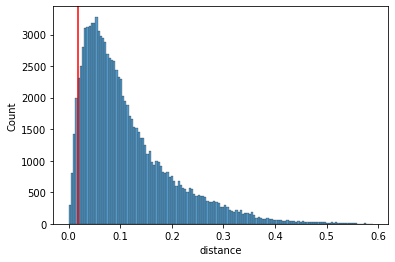

In [138]:
sns.histplot(distances_df['distance'])
plt.axvline(distances_df['distance'].quantile(0.1), color='r')
print(distances_df['distance'].quantile(0.1))

In [139]:
# Set distance cutoff
relevant_distances_df = distances_df[distances_df['distance']<=0.018]
print(len(relevant_distances_df))

4908


In [140]:
#number of 
len(pd.concat([relevant_distances_df['track1'],relevant_distances_df['track2']]).unique())

427

#### Load Data in a Graph

In [141]:
G = nx.from_pandas_edgelist(relevant_distances_df,\
                           source='track1_name', target='track2_name',\
                           edge_attr='distance')
G

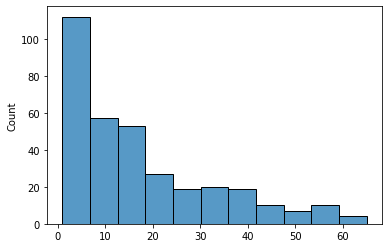

In [142]:
degrees = [G.degree(n) for n in G.nodes()]
sns.histplot(degrees)

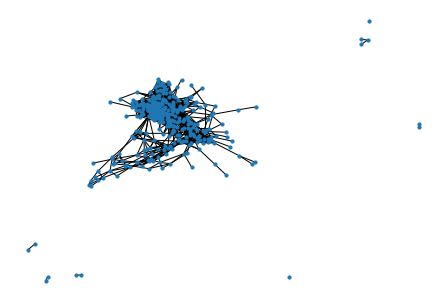

In [153]:
nx.draw_spring(G,node_size=10, font_color='k' )

In [143]:
#get sorted betweenness centrality
sorted(nx.betweenness_centrality(G).items(), key=lambda item: item[1], reverse=True)

[('Midnight Sky', 0.12292326740341247),
 ('Kahit Ayaw Mo Na', 0.0660484519859361),
 ('thank u, next', 0.061654841891337436),
 ('Wrong', 0.05202463488844577),
 ('Circles', 0.045658757363878914),
 ('Speechless (Full)', 0.04099633824880603),
 ('Kathang Isip', 0.04091728371663486),
 ('I Choose - From The Netflix Original Film The Willoughbys',
  0.03924346808474942),
 ('Dance Monkey', 0.03675147668436197),
 ('Balang Araw', 0.031130177079953563),
 ('Psycho', 0.030021717099012024),
 ('Akala', 0.028993155164855566),
 ('OXYGEN', 0.028559599899197992),
 ('Lose', 0.028536421314747307),
 ('Supalonely', 0.02698216934651098),
 ('Dalaga', 0.026906598479753095),
 ("always, i'll care", 0.02678117986305481),
 ('Trampoline (with ZAYN)', 0.026402660018830907),
 ('mirrorball', 0.02550812725836366),
 ('Stay Gold', 0.02538754865613892),
 ('Zebbiana', 0.024738457258910697),
 ('peace', 0.023854286604354367),
 ('Sad Forever', 0.023821749697366206),
 ('Forever (feat. Post Malone & Clever)', 0.02321690352905507)

In [144]:
neighbor_recommendations = nx.single_source_shortest_path_length(G, 'FANCY', cutoff=1)
neighbor_recommendations

{'FANCY': 0,
 'Rewrite The Stars (with James Arthur & Anne-Marie)': 1,
 'Close To Me (with Diplo) (feat. Swae Lee)': 1,
 '달라달라 DALLA DALLA': 1,
 '달라달라 (DALLA DALLA)': 1,
 'ROXANNE': 1,
 'Rain On Me (with Ariana Grande)': 1,
 'Sour Candy (with BLACKPINK)': 1}

In [127]:
def get_random_neighbor(G,node, collected_list):
    return [n for n in G.neighbors(node) if n not in collected_list][0]

In [129]:
seed_track="FANCY"

target_num_recoms=10
recommendations = []
current_node = seed_track
recommendations.append(seed_track)

for i in np.arange(target_num_recoms):
    recommendations.append(get_random_neighbor(G, current_node, recommendations))
    current_node=recommendations[-1]
recommendations        

['Rewrite The Stars (with James Arthur & Anne-Marie)',
 'Close To Me (with Diplo) (feat. Swae Lee)',
 'DDU-DU DDU-DU',
 'Sa Ngalan Ng Pag-Ibig',
 'Bulong',
 'Kahit Di Mo Alam',
 "Kung 'Di Rin Lang Ikaw",
 'Hindi Na Nga',
 'Love Someone',
 "break up with your girlfriend, i'm bored"]

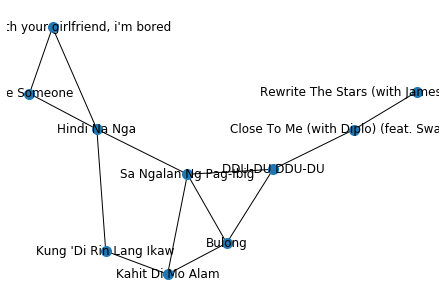

In [155]:
Grecos = G.subgraph(recommendations)
nx.draw_spring(Grecos, with_labels=True, node_size=100, font_color='k' )


### 3. Building a Recommendation Graph Structure: Predicted Genre Score

In [160]:
#create edge list
feature_cols = [col for col in chart_tracks_df.columns if "_prob" in col][1:]

#loop over all tracks
distances=np.zeros(len(track_pairs))
for n,tracks in enumerate(track_pairs):
    if (n % 1000 == 0):
        print( "Computed pairwise distances for %d/%d track pairs..." % (n+1,len(track_pairs)))

    track1_measures = chart_tracks_df[chart_tracks_df['track_id']==tracks[0]]\
                                     [feature_cols].values.reshape(1, -1)
    track2_measures = chart_tracks_df[chart_tracks_df['track_id']==tracks[1]]\
                                         [feature_cols].values.reshape(1, -1) 
    distances[n] = 1-cosine_similarity(track1_measures,track2_measures).flatten()[0]
    

distances_df = pd.DataFrame({'track1':[t[0] for t in track_pairs],\
                             'track1_name':[track_names_dict[t[0]] for t in track_pairs],\
                            'track2':[t[1] for t in track_pairs],\
                            'track2_name':[track_names_dict[t[1]] for t in track_pairs],\
                            'distance': distances})
distances_df

Computed pairwise distances for 1/104653 track pairs...
Computed pairwise distances for 1001/104653 track pairs...
Computed pairwise distances for 2001/104653 track pairs...
Computed pairwise distances for 3001/104653 track pairs...
Computed pairwise distances for 4001/104653 track pairs...
Computed pairwise distances for 5001/104653 track pairs...
Computed pairwise distances for 6001/104653 track pairs...
Computed pairwise distances for 7001/104653 track pairs...
Computed pairwise distances for 8001/104653 track pairs...
Computed pairwise distances for 9001/104653 track pairs...
Computed pairwise distances for 10001/104653 track pairs...
Computed pairwise distances for 11001/104653 track pairs...
Computed pairwise distances for 12001/104653 track pairs...
Computed pairwise distances for 13001/104653 track pairs...
Computed pairwise distances for 14001/104653 track pairs...
Computed pairwise distances for 15001/104653 track pairs...
Computed pairwise distances for 16001/104653 track pa

,track1,track1_name,track2,track2_name,distance
0,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",5f9808hpiCpuNyqqdXmpF2,Buwan,1.000000
1,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",2BgD4nRyx9EZ5o8YEnjRSV,Kung 'Di Rin Lang Ikaw,0.552786
2,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",1X4l4i472kW5ofFP8Xo0x0,Sana,0.811018
3,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",5V2AX2WTOHl2FKtftvisV6,Kahit Ayaw Mo Na,0.329180
4,2rPE9A1vEgShuZxxzR2tZH,"thank u, next",00mBzIWv5gHOYxwuEJXjOG,Sa Ngalan Ng Pag-Ibig,0.329180
...,...,...,...,...,...
104648,45bE4HXI0AwGZXfZtMp8JR,you broke me first,0ri0Han4IRJhzvERHOZTMr,At My Worst,0.180108
104649,45bE4HXI0AwGZXfZtMp8JR,you broke me first,4lsHZ92XCFOQfzJFBTluk8,You Got It,0.455669
104650,5vPO5ouEv8iedKWxzmSv7b,Lose,0ri0Han4IRJhzvERHOZTMr,At My Worst,0.239361
104651,5vPO5ouEv8iedKWxzmSv7b,Lose,4lsHZ92XCFOQfzJFBTluk8,You Got It,0.614242


0.17841616374225078
0.16333997346592444


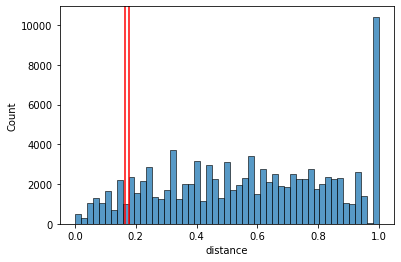

In [167]:
sns.histplot(distances_df['distance'])
plt.axvline(distances_df['distance'].quantile(0.1), color='r')
plt.axvline(distances_df[distances_df['distance']<0.9]['distance'].quantile(0.1), color='r')
print(distances_df['distance'].quantile(0.1))
print(distances_df[distances_df['distance']<0.9]['distance'].quantile(0.1))

In [207]:
# Set distance cutoff
relevant_distances_df = distances_df[distances_df['distance']<=0.1]
print(len(relevant_distances_df))

4210


In [208]:
#number of tracks
len(pd.concat([relevant_distances_df['track1'],relevant_distances_df['track2']]).unique())

448

In [209]:
# Build graph from pandas
G = nx.from_pandas_edgelist(relevant_distances_df,\
                           source='track1_name', target='track2_name',\
                           edge_attr='distance')

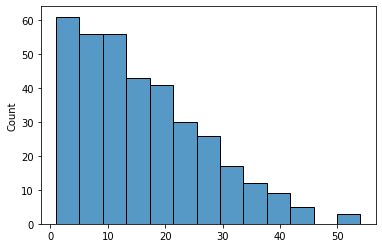

In [210]:
degrees = [G.degree(n) for n in G.nodes()]
sns.histplot(degrees)

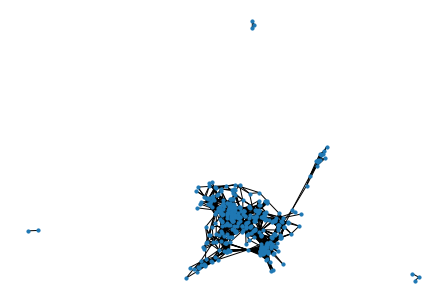

In [211]:
nx.draw_spring(G,node_size=10, font_color='k' )

In [212]:
#Pick a seed track, and traverse the graph one edge at a time to identify next track
seed_track="Kill This Love"

target_num_recoms=10
recommendations = []
current_node = seed_track
recommendations.append(seed_track)

for i in np.arange(target_num_recoms):
    recommendations.append(get_random_neighbor(G, current_node, recommendations))
    current_node=recommendations[-1]
recommendations        

['Kill This Love',
 'Missin You Crazy',
 'DDU-DU DDU-DU',
 'Kick It',
 'Dream Glow (BTS World Original Soundtrack) - Pt. 1',
 'Never Really Over',
 'Rewrite The Stars (with James Arthur & Anne-Marie)',
 'Ruin My Life',
 'On My Way',
 'FANCY',
 'Pauwi Nako']

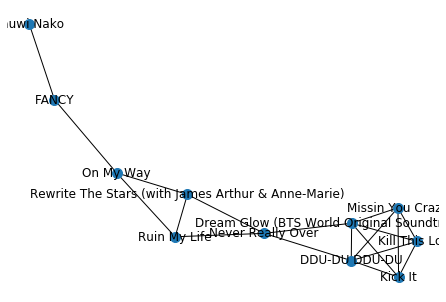

In [213]:
Grecos = G.subgraph(recommendations)
nx.draw_spring(Grecos, with_labels=True, node_size=100, font_color='k' )

In [214]:
#recommendations are all nodes in between a source and target
nx.shortest_path(G, source='Kathang Isip', target='WAP (feat. Megan Thee Stallion)')

['Kathang Isip',
 'Lucid Dreams',
 'Best Part of Me (feat. YEBBA)',
 'Repeat',
 'CIVIL WAR - Bonus',
 'Easier',
 'Taki Taki (with Selena Gomez, Ozuna & Cardi B)',
 'WAP (feat. Megan Thee Stallion)']